## Fundamentals of Social Data Science
# Week 4 Day 1 Lab. Classification 

In this lab, you will be encouraged to explore your subreddits of choice using multinomial naive bayes and k-means classifications. Determine which one is more suitable using accuracy scores. Use both the TfIDFVectorizer and the CountVectorizer. 

Consider the use of stop words and lemmatisation. 

1. Plot the documents using t-SNE and then color the documents according the most accurate solution. 
2. For Naive Bayes report the 5 most informative terms per solution.  
* Would you be able to report the 5 most informative terms with k-means? This would be a bit far out for this lecture but if you are adventurous you can explore approaches like k-nearest neighbors using the centroids (as in report the 5 nearest neighbors to the centroid for each of the k solutions). 

There is only limited example code for this exercise. It is up to you to stitch together what you have learned as well as potentially draw upon external sources. On Wednesday we will provide an example solution.

Some guidance: 
1. Transform your headlines into a list similar to the walkthrough: [("headline (and maybe selftext)", "subreddit_label"), ("next headline", "next subreddit_label")]
 * Create one long list for all three subreddits to send to the Vectorizer. This is different to what I showed in Week 3 Day 3 where we had a separate vectorizer for each subreddit. To help you out I've started some code that creates a DataFrame for all the subs. 
2. Consider your tokenization. Will you use stop words or not? 
3. Consider plotting the classification on t-SNE to get some intuitions for how the solution maps out visually. 
4. Remember, are you classifying the documents using the terms? Or classifying the terms using the documents? Be careful with how you set this up. Notice that in the examples in the walkthrough we were classifying the documents using the terms. 
5. Consider the structure of this repository. Will you want to place some code for a plotting function in the `analysis.py`? What about creating a function under `text_processor.py` to transform the reddit data into the data structure needed. You can do everything in this Jupyter lab notebook but you should use this opportunity to think about how you might make use of this structure in order to help keep your code tidy. 


In [1]:
import os
import pickle
from models.reddit_scraper import RedditScraper
from config.settings import USER_AGENT
from utils.analysis import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

scraper = RedditScraper(USER_AGENT)
subs_of_interest = ['ValueInvesting', 'WallStreetBets', 'investing']

posts_list = []

for sub in subs_of_interest:    
    posts = scraper.get_subreddit_posts(sub, limit=500, cache=True)
    df = create_posts_dataframe(posts)
    df['subreddit'] = sub
    posts_list.append(df)

posts_df = pd.concat(posts_list)
posts_df = posts_df.reset_index(drop=True)


In [2]:
  # Check if posts is indeed a DataFrame
def process_column(posts, include_selftext = False):
    if not isinstance(posts, pd.DataFrame):
      raise ValueError("Input `posts` should be a pandas DataFrame.")
    texts = posts['title'].apply(preprocess_text)
    if include_selftext:
      # Add 'selftext' to each text if requested
      texts += ' ' + posts['selftext'].apply(preprocess_text)

    # Convert texts to a list format for further analysis
    texts = texts.tolist()
    return texts


In [3]:
text = process_column(posts_df, True)
tfidf_matrix, feature_names = generate_tfidf_matrix(text)
tfidf_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 11346 stored elements and shape (300, 1000)>

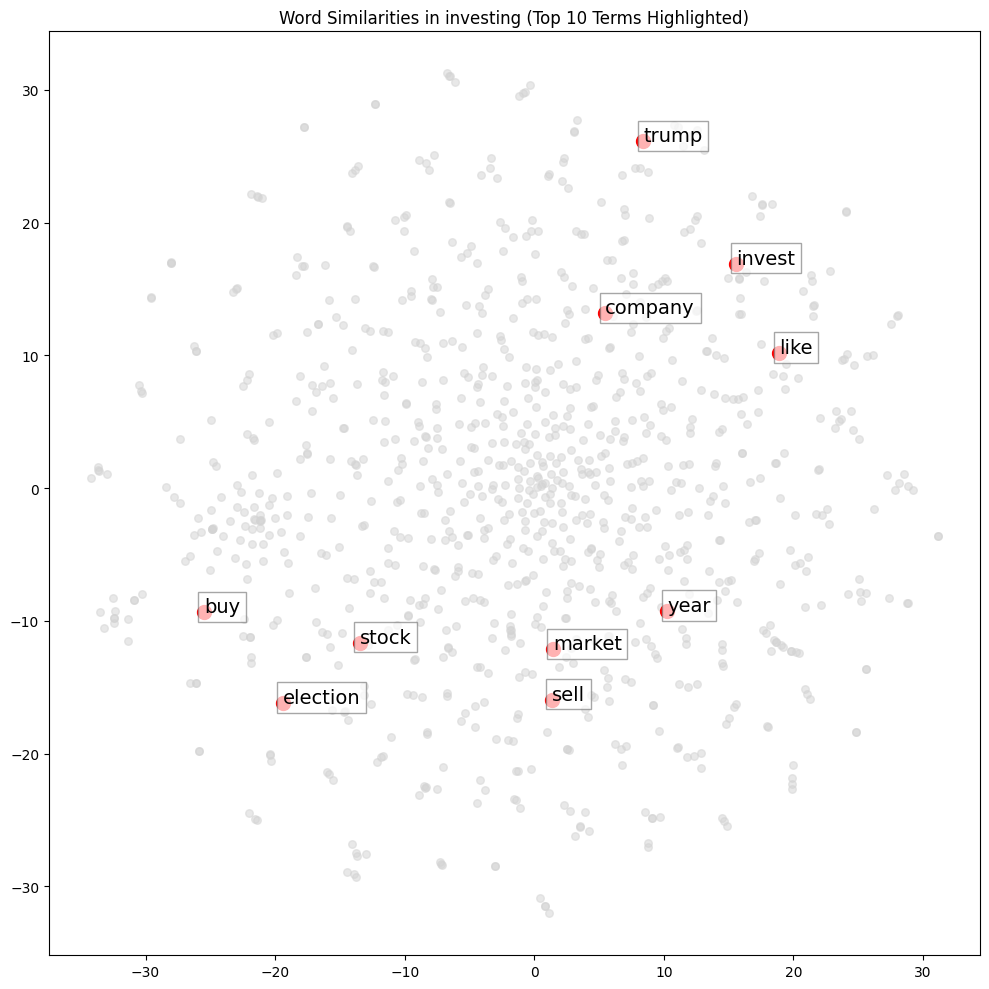

In [4]:
from utils.analysis import plot_word_similarities_tsne

fig, ax = plot_word_similarities_tsne(tfidf_matrix, 
                                    feature_names,
                                    n_highlight=10, # Try changing this value
                                    title=sub)
plt.show();

In [5]:
corpus_text = posts_df['title'].tolist()
corpus_labels = posts_df['subreddit'].tolist()

In [6]:
# Naive Bayes Classifier

# Create TF-IDF matrix
vectorizer = TfidfVectorizer(min_df=2)
# vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
X = vectorizer.fit_transform(corpus_text)

nbc = plot_multinomialNB(X, corpus_labels)

Naive Bayes Classification Results:
                precision    recall  f1-score   support

ValueInvesting       0.65      0.57      0.61        35
WallStreetBets       0.64      0.50      0.56        28
     investing       0.46      0.63      0.53        27

      accuracy                           0.57        90
     macro avg       0.58      0.57      0.57        90
  weighted avg       0.59      0.57      0.57        90



Summarise NBC results: 


In [7]:
# Naive Bayes Classification
vectorizer = CountVectorizer(min_df=2, stop_words='english')
X = vectorizer.fit_transform(corpus_text)
nbc = plot_multinomialNB(X, corpus_labels)

Naive Bayes Classification Results:
                precision    recall  f1-score   support

ValueInvesting       0.66      0.66      0.66        35
WallStreetBets       0.88      0.54      0.67        28
     investing       0.45      0.63      0.52        27

      accuracy                           0.61        90
     macro avg       0.66      0.61      0.62        90
  weighted avg       0.66      0.61      0.62        90



In [8]:
# Report most informative features
def most_informative_features(vectorizer, classifier, n=10):
    feature_names = vectorizer.get_feature_names_out()
    class_labels = classifier.classes_
    top_features = {}

    for i, class_label in enumerate(class_labels):
        top_indices = classifier.feature_log_prob_[i].argsort()[-n:][::-1]
        top_features[class_label] = [(feature_names[j], classifier.feature_log_prob_[i][j]) for j in top_indices]

    return top_features

# Naive Bayes Classification
# Split data for NBC
X_train, X_test, y_train, y_test = train_test_split(
    X, corpus_labels, test_size=0.3, random_state=42
)

# Naive Bayes Classification
nbc = MultinomialNB()
nbc.fit(X_train, y_train)
nbc_pred = nbc.predict(X_test)
top_features = most_informative_features(vectorizer, nbc, n=5)
print("\nTop Features per Class:")
for class_label, features in top_features.items():
    print(f"\nClass: {class_label}")
    for feature, log_prob in features:
        print(f"  {feature}: {np.exp(log_prob):.4f}")


Top Features per Class:

Class: ValueInvesting
  value: 0.0124
  market: 0.0124
  trump: 0.0099
  time: 0.0099
  stock: 0.0099

Class: WallStreetBets
  earnings: 0.0241
  trump: 0.0153
  tesla: 0.0153
  today: 0.0131
  gains: 0.0109

Class: investing
  best: 0.0167
  stocks: 0.0125
  401k: 0.0125
  advice: 0.0125
  discussion: 0.0125


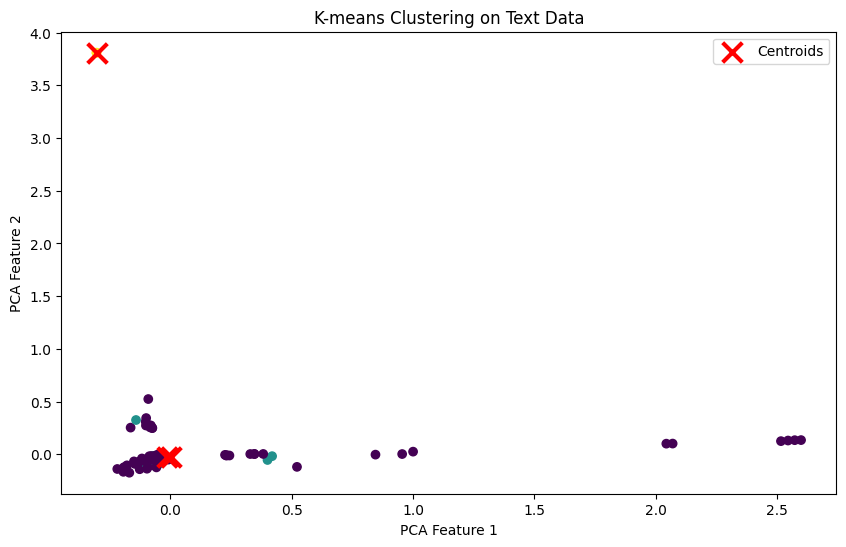

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = CountVectorizer(min_df=2, stop_words='english')
X = vectorizer.fit_transform(corpus_text)
plot_kmeans(X,3)


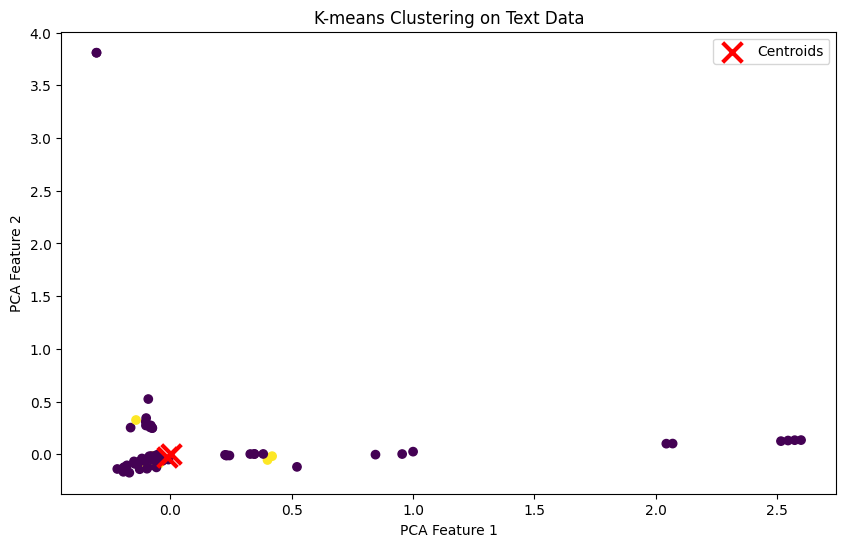

In [10]:
plot_kmeans(X,2)

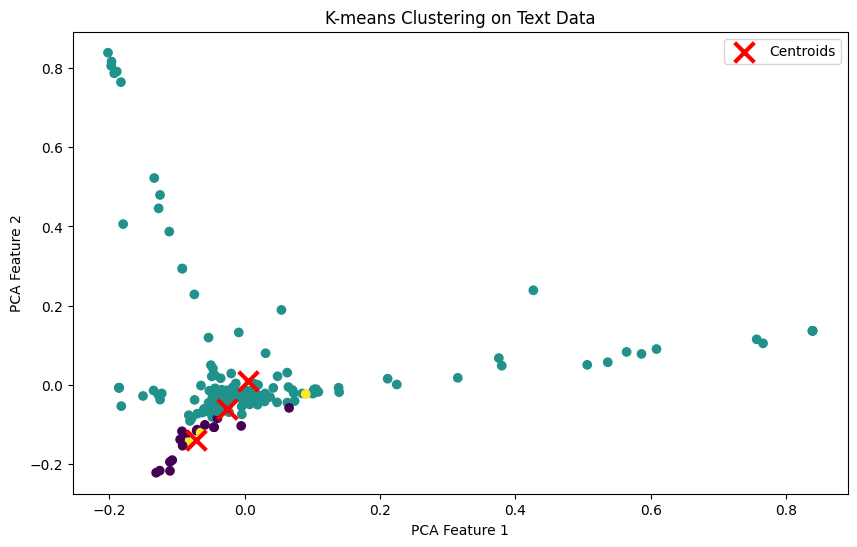

In [11]:
vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
X = vectorizer.fit_transform(corpus_text)
plot_kmeans(X,3)


Summarise k-Means results

the three reddits are very similar to each other.